In [51]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


Loading Dataset


In [ ]:
from datasets import load_dataset
dataset = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [ ]:
def get_tweet(data):
  tweets =[x['text'] for x in data]
  labels =[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets,labels=get_tweet(train)

In [ ]:
tweets[5],labels[3]

('ive been feeling a little burdened lately wasnt sure why that was', 2)

Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

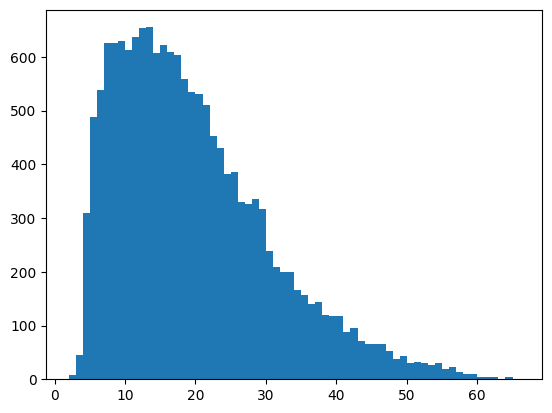

In [ ]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

Padding

In [ ]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded_sequence=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded_sequence

In [ ]:
padded_training_seq=get_sequences(tokenizer,tweets)

In [ ]:
padded_training_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


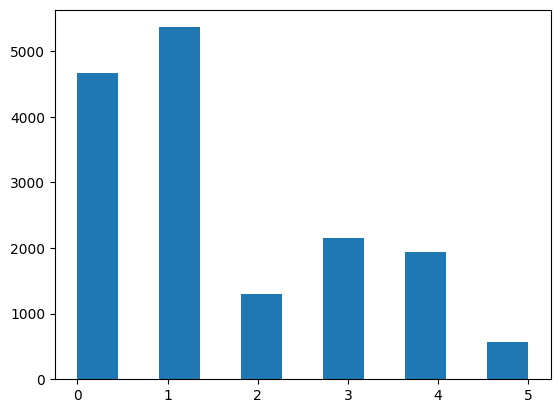

In [ ]:
plt.hist(labels,bins=11)
plt.show()

model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')

])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the Model

In [ ]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)

In [ ]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
padded_training_seq = np.array(padded_training_seq)
val_seq = np.array(val_seq)

labels = np.array(labels)
val_labels = np.array(val_labels)

In [ ]:
history = model.fit(
    padded_training_seq,
    labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)


Epoch 1/20
500/500 [==============================] - 38s 61ms/step - loss: 1.3864 - accuracy: 0.3784 - val_loss: 1.2146 - val_accuracy: 0.4535
Epoch 2/20
500/500 [==============================] - 30s 60ms/step - loss: 0.8476 - accuracy: 0.6680 - val_loss: 0.6803 - val_accuracy: 0.7635
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.4834 - accuracy: 0.8442 - val_loss: 0.5127 - val_accuracy: 0.8350
Epoch 4/20
500/500 [==============================] - 29s 57ms/step - loss: 0.3356 - accuracy: 0.8942 - val_loss: 0.5298 - val_accuracy: 0.8405
Epoch 5/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2527 - accuracy: 0.9184 - val_loss: 0.4486 - val_accuracy: 0.8550
Epoch 6/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1818 - accuracy: 0.9455 - val_loss: 0.4069 - val_accuracy: 0.8825
Epoch 7/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1476 - accuracy: 0.9566 - val_loss: 0.4138 - val_accuracy:

In [ ]:
test_tweets,test_labels=get_tweet(test)
test_tweets_sequencial=get_sequences(tokenizer,test_tweets)
test_tweets_sequencial=np.array(test_tweets_sequencial)
test_labels = np.array(test_labels)

In [ ]:
model.evaluate(test_tweets_sequencial, test_labels)

63/63 [==============================] - 2s 32ms/step - loss: 0.4258 - accuracy: 0.8770


[0.425824373960495, 0.8769999742507935]

In [ ]:
index_class={0:'sad',1:'joy',2:'love',3:'anger',4:'fear',5:'suprise'}

In [ ]:
i=random.randint(0,len(test_labels)-1)

print('sentence : ',test_tweets[i])
print('emotion : ',index_class[test_labels[i]])

p=model.predict(np.expand_dims(test_tweets_sequencial[i],axis=0))[0]
pred_class=index_class[np.argmax(p).astype('uint8')]

print('prediction : ',pred_class)

sentence :  i got home feeling hot tired and great
emotion :  love
1/1 [==============================] - 0s 27ms/step
prediction :  love


In [ ]:
pred=model.predict(test_tweets_sequencial)
pred=np.argmax(pred,axis=1)

63/63 [==============================] - 1s 21ms/step


In [55]:
import seaborn
import sklearn

<Axes: >

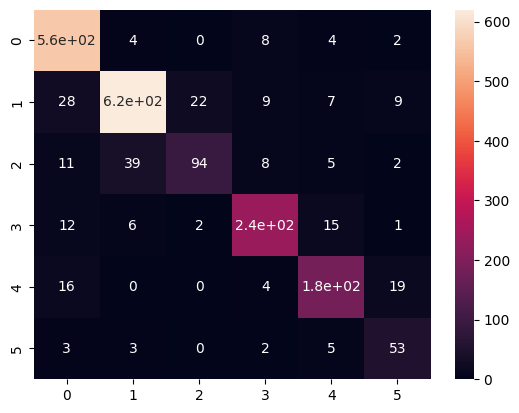

In [57]:
seaborn.heatmap(sklearn.metrics.confusion_matrix(test_labels,pred),annot=True)